In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
from numpy.random import randint 
import numpy as np
from qiskit_ibm_provider import IBMProvider
from math import sqrt
import random
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#user input example 
# node = 4 , edge_connection = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]  all node connected square
#node = 5, edge_connection [[0,1],[1,2],[2,3],[3,4],[0,4]]  pentagon
number_of_nodes = 7
edge_connections =  [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,0]]
# number_of_iteration = 2
shots = 1

In [3]:
# qubits preparation

node_qubit_1D = [i for i in range(number_of_nodes*2)]
node_qubits_2D = [node_qubit_1D[i:i+2] for i in range(0, len(node_qubit_1D), 2)]


number_of_edge = len(edge_connections)
edge_qubits = [number_of_nodes*2 + i for i in range (number_of_edge)]
a = [number_of_nodes * 2  + len(edge_connections)]
all_qubits = node_qubit_1D + edge_qubits + a

print('number_of_nodes',number_of_nodes)
print('node_qubit_1D',node_qubit_1D)
print('node_qubits_2D',node_qubits_2D)

print('edge_connections',edge_connections)
print('edge_qubits',edge_qubits)
print('number_of_edge',number_of_edge)

print('ancilla',a)

print('all_qubits',all_qubits)



number_of_nodes 7
node_qubit_1D [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
node_qubits_2D [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13]]
edge_connections [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 0]]
edge_qubits [14, 15, 16, 17, 18, 19, 20]
number_of_edge 7
ancilla [21]
all_qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [4]:
#all required function are defined


def initialization(qr): # qr takes 1D list of qubits of nodes 
    qc.h(qr)
    qc.barrier()
    
def color_check(q0, q1, q2, q3, e):
    
    #optimised color check
    qc.x([q2,q3])    
    qc.mct([q0,q1], e)

    qc.mct([q1,q2], e)

    qc.mct([q2,q3], e)

    qc.mct([q0,q3], e)
    qc.x([q2,q3])
    
    qc.barrier()
       
def color_check_inverse(q0, q1, q2, q3, e):

    #optimised color check
    qc.x([q2,q3])    
    qc.mct([q0,q3], e)

    qc.mct([q2,q3], e)        

    qc.mct([q1,q2], e)
    
    qc.mct([q0,q1], e)
    qc.x([q2,q3])    
       
    qc.barrier()

    
def nodes_qubits(e): # is the edge connections element 
    '''takes 1 edge connection 1D list and return the qubit accociated with it 1D list
        returns : list of qubits/ nodes connected by the edge e
    '''
    return node_qubits_2D[e[0]] + node_qubits_2D[e[1]]
 

def oracle (edge_connections, a): #edge_connections = [[0,1],[0,2],[1,2]]
    '''Parameter :
        edge_connection 2D list of our edge connected with nodes
        a is 1D list of ancillay/ result qubit
    '''
    qc.barrier()
    
    #color check function
    for edge_index, e in enumerate(edge_connections):
        qubits = nodes_qubits(e)
        q1, q2, q3, q4 = qubits[0], qubits[1], qubits[2], qubits[3]
        color_check(q1,q2,q3,q4, edge_index+number_of_nodes*2) # the constant 6 could be replaced with len(nodes*2 or len(nu of qubits for nodes
          
    #phase kickback
    qc.mct(edge_qubits , a[0]) # a index to 0 which is the only one 
    qc.barrier()
    
    
        #mirror
    
    for  edge_index, e in enumerate(edge_connections[::-1]): # start one
            qubits = nodes_qubits(e)
            q1, q2, q3, q4 = qubits[0], qubits[1], qubits[2], qubits[3]
            color_check_inverse(q1,q2,q3,q4, len(edge_connections)-edge_index+number_of_nodes*2-1)
     
    #optional
    #reinitilize memory 
    # qc.x(edge_qubits)
    qc.barrier()
    

#diffucsion operator
def diffusion_inversion(node_qubit_1D,a):    # diffusion at ancilla  
    '''Parameter :
            node_quit_1D : 1 D list of node qubit
            a : 1D list of ancilla used
       
    '''
    initialization(node_qubit_1D)
    qc.x(node_qubit_1D)
    qc.mct(node_qubit_1D, a[0]) # multi control gate 
    qc.x(node_qubit_1D)
    qc.x(a[0])
    initialization(node_qubit_1D)
    

    
def state_preparation(node_qubit_1D, edge_qubits,a): 
    
    '''Implement initialization to node_qubit , apply x to edge qubit and ancilla to |-> state'''
    initialization(node_qubit_1D) 
    qc.x(edge_qubits)
    
    # ancilla in \-> state
    qc.x(a[0])
    qc.h(a[0])





def Grovers(node_qubit_1D, edge_qubits, a, number_of_iteration, shots):
    '''
        Parameter: 
            node_qubit_1D: list of node qubits
            edge_qubits: list of edge qubits
            a: list of ancilla qubits
            number_of_iteration: no of interation for grovers
            shots: number of shots for measuring
            
        Return: 
            count: count after measuring the circuit in backend
    '''
    
    all_qubits = node_qubit_1D + edge_qubits + a
    no_of_qubits = len(all_qubits)
    no_of_bits = len(node_qubit_1D)

    
    qc.reset(node_qubit_1D) 
    state_preparation(node_qubit_1D, edge_qubits,a)
    
    for i in range(number_of_iteration):
        oracle(edge_connections, a)
        diffusion_inversion(node_qubit_1D, a)
    qc.measure(node_qubit_1D,node_qubit_1D)
    job = execute(qc, backend=backend, shots=shots) # shots = shots for genera;
    result = job.result()
    count = str(result.get_counts())
    count=count[2:len(node_qubit_1D)+2] # retrun only the binary_string 
    return count

def check_adjacent_colors(colors, edge_connections):
    '''
        Parameters:
            color : list of binary string in color coding
            edge_connection : 2D list of edges
        Return:  True if color is different
    '''

    
    for edge in edge_connections:
        vertex1, vertex2 = edge
        color1, color2 = colors[vertex1], colors[vertex2]
        if color1 == color2:
            return False
    return True


        
def loop(node_qubit_1D, edge_qubits, a, shots, n):
    ''' 
        implement the grovers for no_of_iteration times 
        Parameter : 
            a : ancilla
            shots : shots for measurement
            n is the parameter that is need to be updated until correct solution 
        
        retrun count and no of iteration used
    '''
    
    p= sqrt(4**number_of_nodes) 
    if n<p:
        x=n
    else:
        x=p
    
    number_of_iteration=random.randint(0,floor(x)) 
    count = Grovers(node_qubit_1D, edge_qubits, a, number_of_iteration, shots)
    return count, number_of_iteration


#idk what this is
def draw_node(binary_string , edge_connections, number_of_nodes ):
    if len(binary_string) != number_of_nodes * 2:
        print(f"Error: The binary string must be {number_of_nodes*2} digits long.")
        return

    # Define the colors based on binary representation
    color_map = {
        '00': 'red',
        '11': 'yellow',
        '01': 'blue',
        '10': 'green'
    }
    colors = [color_map[binary_string[i:i+2]] for i in range(0, len(binary_string), 2)]


    G = nx.Graph()
    G.add_nodes_from(range(number_of_nodes)) # number of nodes

    
    G.add_edges_from(edge_connections)

    # Draw the graph with specified colors
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=2000)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    plt.axis('off')
    plt.show()



    

    

In [5]:

#creating the circuit
no_of_qubits = len(all_qubits)
no_of_bits = len(node_qubit_1D)
qc = QuantumCircuit(no_of_qubits, no_of_bits)

#backed
backend = Aer.get_backend('qasm_simulator')

#some constants
m=1
l= 1.2
color_mapping = {
    '00': 'red',
    '01': 'blue',
    '10': 'green',
    '11': 'yellow'
}



Number of iteration :  0
00011011000111
Solution is valid! Adjacent colors are different, Required number of iteration is :  0
00011011000111


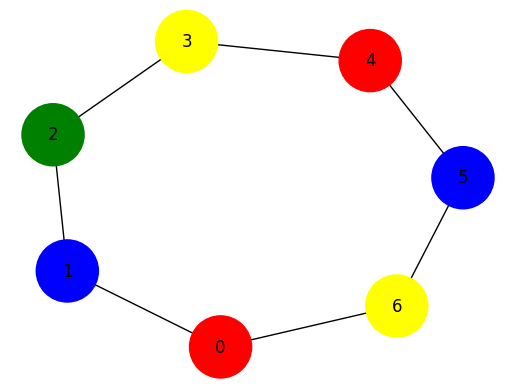

In [6]:
while True:
        count, number_of_iteration =loop(node_qubit_1D, edge_qubits,a, shots, m)
        
        print("Number of iteration : ", number_of_iteration)
        print(count)
        colors = [color_mapping[count[i:i+2]] for i in range(0, len(node_qubit_1D), 2)]

        if check_adjacent_colors(colors, edge_connections):
            print("Solution is valid! Adjacent colors are different, Required number of iteration is : ", number_of_iteration)
            print(count)
            draw_node(count , edge_connections, number_of_nodes)
            break 
            
        else:
            m=m*l
            
            print('m = ', m)
